# Train Classifier for Synthetic Data 2

In [1]:
from models.TCN import TCN_fit_pipeline, FastDataLoader

import numpy as np
import pandas as pd
import torch
import wandb

%load_ext autoreload
%autoreload 2

In [ ]:
from models.TCN.utils import get_data_loader_synthetic

### Get data right

In [2]:
def get_dataloader(path, batch_size, drop_time=True):
    # drop time ignores the time column
    # get data path to data 

    df = pd.read_csv(path, compression="gzip")
    df = pd.pivot_table(df, index=["id", "time"], columns="variable", values="value").reset_index(level=[0, 1])
    if drop_time == True:
        df = df.drop(columns=["time"])
    print(df.shape)
    grouped = df.groupby("id")
    input_features = len(df.columns) - 2
    print(df.columns, '\n')
    print(df.tail(), '\n')
    print('Number of samples: ', len(grouped))

    # Get batches
    batch_representation = np.stack([i[1].iloc[:,1:] for n, i in enumerate(grouped)])
    batch_representation = batch_representation.astype(np.float64)

    # get dataloader
    dataloader = FastDataLoader(batch_representation, batch_size, 1)
    print("Batch.shape: ", next(iter(dataloader)).shape)
    input_features = next(iter(dataloader)).shape[-1] -1  # -1 for the label
    
    # get class imbalance factor
    prop_cases = df['Y_ts'].mean()
    pos_weight = torch.tensor((1 - prop_cases) / prop_cases)
    print('pos_weight: ', pos_weight)
    return dataloader, input_features, pos_weight


path = "~/Documents/data/ts/synthetic_2/fully_observed/synthetic_2_ts_eav.csv.gz"
batch_size = 2000
drop_time = True
dataloader, input_features, pos_weight = get_dataloader(path, batch_size, drop_time)

(100000, 6)
Index(['id', 'X0_ts', 'X1_ts', 'X2_ts', 'X3_ts', 'Y_ts'], dtype='object', name='variable') 

variable    id     X0_ts     X1_ts     X2_ts     X3_ts  Y_ts
99995     1999 -0.526578 -1.155559  0.323330  0.003595   1.0
99996     1999  0.687887  0.100261  1.642386  0.423817   0.0
99997     1999  0.782064  1.778468 -0.406455 -1.452343   0.0
99998     1999 -0.594470  0.817426  0.168355 -0.549674   0.0
99999     1999  0.359693  0.300567  0.599232 -0.017969   0.0 

Number of samples:  2000
Batch.shape:  torch.Size([2000, 50, 5])
pos_weight:  tensor(2.0632, dtype=torch.float64)


### Pos_weight 

Calculate the imbalence of labels in the train dataset

In [17]:
prop_cases = df['Y_ts'].mean()
pos_weight = torch.tensor((1 - prop_cases) / prop_cases)
print(pos_weight)

tensor(2.0632, dtype=torch.float64)


# TRAINING

First the config then run the training pipeline. 

## Grid Search

In [ ]:
for i in [2, 4, 8, 16, 32, 64, 128]:
    for j in [2, 4, 8, 16, 32, 64, 128]:
        # generate random number between 0 and 1
        
        dropout = np.random.uniform(0, 0.5)
        config = {
            'seed': 65,
            'model_type': 'TCN', 
            'time excluded': (input_features==4),
            'num_inputs': input_features,
            'num_channels': [i, i],
            'kernel_size': 2,
            'dropout': dropout,
            'lr': 0.01,
            'max_epochs': 1000,
            'batch_size': batch_size
            }

        TCN_fit_pipeline(dataloader, None, input_features, "classifier synthetic 2", pos_weight, config=config)

In [4]:
from .models.TCN.utils import get_data_loader_synthetic

ImportError: attempted relative import with no known parent package

# Hyperparameter Search by Josh

(100000, 6)
Index(['id', 'X0_ts', 'X1_ts', 'X2_ts', 'X3_ts', 'Y_ts'], dtype='object', name='variable') 

variable    id     X0_ts     X1_ts     X2_ts     X3_ts  Y_ts
99995     1999 -0.526578 -1.155559  0.323330  0.003595   1.0
99996     1999  0.687887  0.100261  1.642386  0.423817   0.0
99997     1999  0.782064  1.778468 -0.406455 -1.452343   0.0
99998     1999 -0.594470  0.817426  0.168355 -0.549674   0.0
99999     1999  0.359693  0.300567  0.599232 -0.017969   0.0 

Number of samples:  2000


Global seed set to 65


Batch.shape:  torch.Size([2000, 50, 5])
pos_weight:  tensor(2.0632, dtype=torch.float64)
------------- Run 0 out of 3 ------------------


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: joshwe. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  32
TCN_lightning(
  (loss): MaskedBCEWithLogitsLoss()
  (model): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1dWithWN(4, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.28999999165534973, inplace=False)
        (conv2): Conv1dWithWN(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.28999999165534973, inplace=False)
        (net): Sequential(
          (0): Conv1dWithWN(4, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.28999999165534973, inplace=False)
          (4): Conv1dWithWN(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.28999999165534973, inplac

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | loss  | MaskedBCEWithLogitsLoss | 0     
1 | model | TemporalConvNet         | 2.6 K 
2 | fc    | Sequential              | 33    
--------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 6.6000e-04.
Epoch 00043: reducing learning rate of group 0 to 4.3560e-04.
Epoch 00064: reducing learning rate of group 0 to 2.8750e-04.
Epoch 00085: reducing learning rate of group 0 to 1.8975e-04.
Epoch 00106: reducing learning rate of group 0 to 1.2523e-04.
Epoch 00127: reducing learning rate of group 0 to 8.2654e-05.
Epoch 00148: reducing learning rate of group 0 to 5.4552e-05.
Epoch 00169: reducing learning rate of group 0 to 3.6004e-05.
Epoch 00190: reducing learning rate of group 0 to 2.3763e-05.
Epoch 00211: reducing learning rate of group 0 to 1.5683e-05.
Epoch 00232: reducing learning rate of group 0 to 1.0351e-05.
Epoch 00253: reducing learning rate of group 0 to 6.8317e-06.
Epoch 00274: reducing learning rate of group 0 to 4.5089e-06.
Epoch 00295: reducing learning rate of group 0 to 2.9759e-06.
Epoch 00316: reducing learning rate of group 0 to 1.9641e-06.
Epoch 00337: reducing learning rate of group 0 to 1.2963e-06.
Epoch 00

Calculating metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Applying sigmoid to y_pred!
(100000,) (100000,) (100000,) (100000,)
AUROC:  0.9063501581546671


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▆▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
AUROC,0.9064
accuracy,0.79481
epoch,427
lr-Adam,0.0
num_hyperparams,2625
train_loss,0.60959
trainer/global_step,427


Global seed set to 65


------------- Run 1 out of 3 ------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | loss  | MaskedBCEWithLogitsLoss | 0     
1 | model | TemporalConvNet         | 42    
2 | fc    | Sequential              | 3     
--------------------------------------------------
45        Trainable params
0         Non-trainable params
45        Total params
0.000     Total estimated model params size (MB)


Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  2
TCN_lightning(
  (loss): MaskedBCEWithLogitsLoss()
  (model): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1dWithWN(4, 2, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.14000000059604645, inplace=False)
        (conv2): Conv1dWithWN(2, 2, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.14000000059604645, inplace=False)
        (net): Sequential(
          (0): Conv1dWithWN(4, 2, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.14000000059604645, inplace=False)
          (4): Conv1dWithWN(2, 2, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.14000000059604645, inplace=False

/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 6.6000e-04.
Epoch 00043: reducing learning rate of group 0 to 4.3560e-04.
Epoch 00064: reducing learning rate of group 0 to 2.8750e-04.
Epoch 00085: reducing learning rate of group 0 to 1.8975e-04.
Epoch 00106: reducing learning rate of group 0 to 1.2523e-04.
Epoch 00127: reducing learning rate of group 0 to 8.2654e-05.
Epoch 00148: reducing learning rate of group 0 to 5.4552e-05.
Epoch 00169: reducing learning rate of group 0 to 3.6004e-05.
Epoch 00190: reducing learning rate of group 0 to 2.3763e-05.
Epoch 00211: reducing learning rate of group 0 to 1.5683e-05.
Epoch 00232: reducing learning rate of group 0 to 1.0351e-05.
Epoch 00253: reducing learning rate of group 0 to 6.8317e-06.
Epoch 00274: reducing learning rate of group 0 to 4.5089e-06.
Epoch 00295: reducing learning rate of group 0 to 2.9759e-06.
Epoch 00316: reducing learning rate of group 0 to 1.9641e-06.
Epoch 00337: reducing learning rate of group 0 to 1.2963e-06.
Epoch 00

Calculating metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Applying sigmoid to y_pred!
(100000,) (100000,) (100000,) (100000,)
AUROC:  0.6169667342454304


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▆▆▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
AUROC,0.617
accuracy,0.54489
epoch,403
lr-Adam,0.0
num_hyperparams,45
train_loss,0.94015
trainer/global_step,403


Global seed set to 65


------------- Run 2 out of 3 ------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | loss  | MaskedBCEWithLogitsLoss | 0     
1 | model | TemporalConvNet         | 42    
2 | fc    | Sequential              | 3     
--------------------------------------------------
45        Trainable params
0         Non-trainable params
45        Total params
0.000     Total estimated model params size (MB)


Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  2
TCN_lightning(
  (loss): MaskedBCEWithLogitsLoss()
  (model): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1dWithWN(4, 2, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.14000000059604645, inplace=False)
        (conv2): Conv1dWithWN(2, 2, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.14000000059604645, inplace=False)
        (net): Sequential(
          (0): Conv1dWithWN(4, 2, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.14000000059604645, inplace=False)
          (4): Conv1dWithWN(2, 2, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.14000000059604645, inplace=False

/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 6.6000e-04.
Epoch 00043: reducing learning rate of group 0 to 4.3560e-04.
Epoch 00064: reducing learning rate of group 0 to 2.8750e-04.
Epoch 00085: reducing learning rate of group 0 to 1.8975e-04.
Epoch 00106: reducing learning rate of group 0 to 1.2523e-04.
Epoch 00127: reducing learning rate of group 0 to 8.2654e-05.
Epoch 00148: reducing learning rate of group 0 to 5.4552e-05.
Epoch 00169: reducing learning rate of group 0 to 3.6004e-05.
Epoch 00190: reducing learning rate of group 0 to 2.3763e-05.
Epoch 00211: reducing learning rate of group 0 to 1.5683e-05.
Epoch 00232: reducing learning rate of group 0 to 1.0351e-05.
Epoch 00253: reducing learning rate of group 0 to 6.8317e-06.
Epoch 00274: reducing learning rate of group 0 to 4.5089e-06.
Epoch 00295: reducing learning rate of group 0 to 2.9759e-06.
Epoch 00316: reducing learning rate of group 0 to 1.9641e-06.
Epoch 00337: reducing learning rate of group 0 to 1.2963e-06.
Epoch 00

Calculating metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Applying sigmoid to y_pred!
(100000,) (100000,) (100000,) (100000,)
AUROC:  0.6169696125830029


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▆▆▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
AUROC,0.617
accuracy,0.54488
epoch,403
lr-Adam,0.0
num_hyperparams,45
train_loss,0.94016
trainer/global_step,403


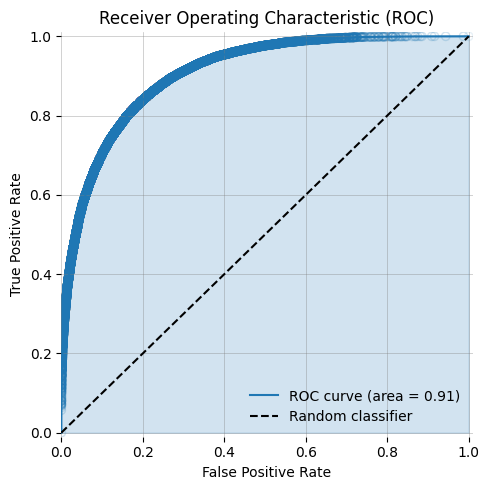

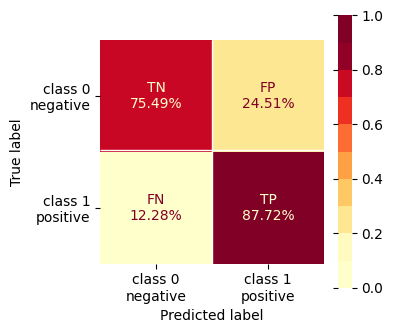

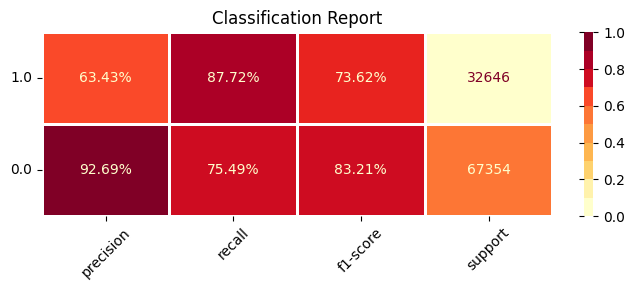

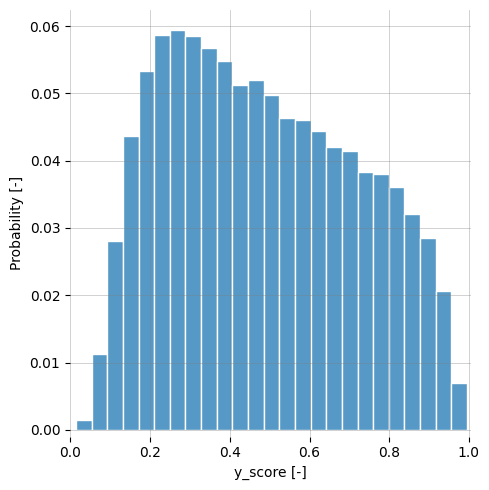

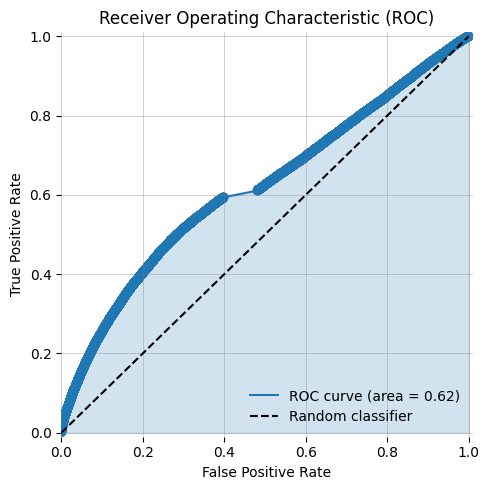

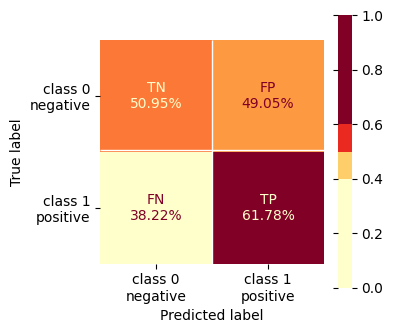

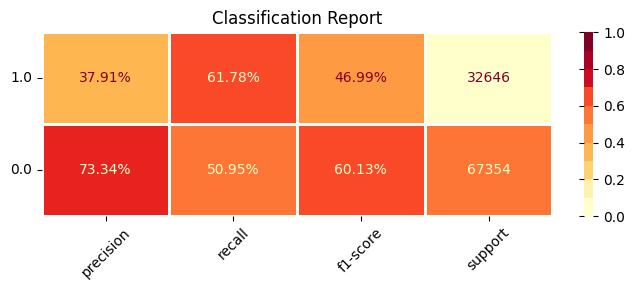

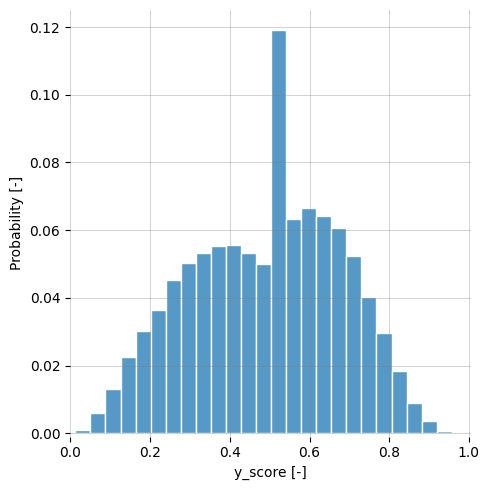

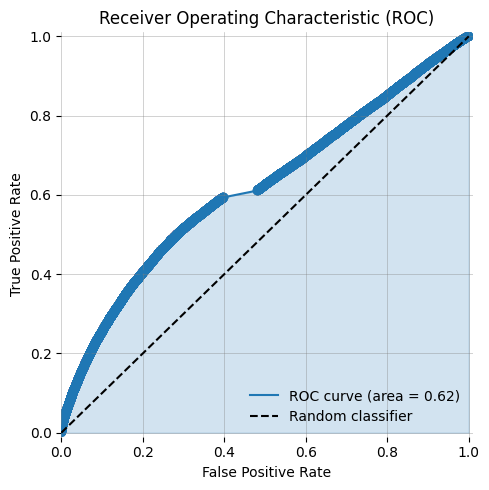

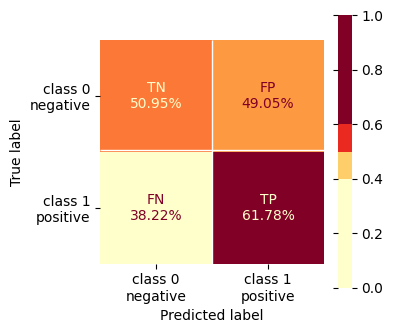

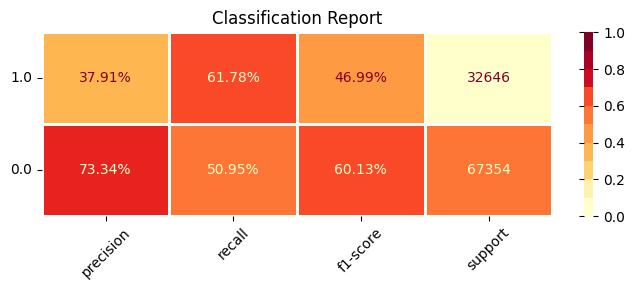

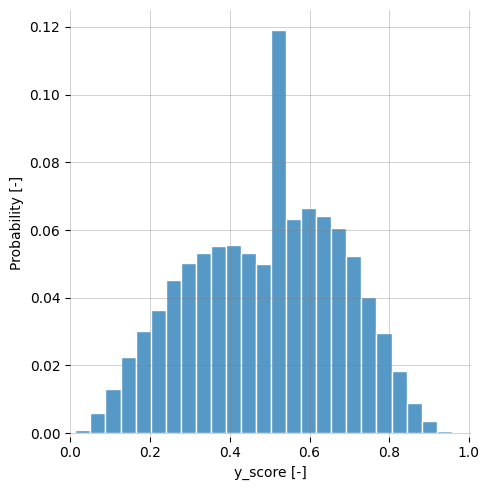

In [3]:
def get_random_hyperparameters():
    config = dict()
    config['num_layers'] = np.random.choice([1,2,3], 1, p=[0.5, 0.3, 0.2])
    config['num_channels'] = np.random.choice([2,4,8,16,32,64,128], config['num_layers'])
    config['dropout'] = torch.tensor(np.random.uniform(0, 0.5).__round__(2))
    return config

def hyper_search(runs: int):
    wandb.finish()
    path = "~/Documents/data/ts/synthetic_2/fully_observed/synthetic_2_ts_eav.csv.gz"
    batch_size = 2000
    drop_time = True
    input_features = 4
    dataloader, input_features, pos_weight = get_data_loader_synthetic(path, batch_size, drop_time)
    config = {
            'seed': 65,
            'model_type': 'TCN', 
            'lr': 0.001,
            'time excluded': (input_features==4),
            'num_inputs': input_features,
            'num_channels': [-1],
            'kernel_size': 2,
            'max_epochs': 1000,
            'batch_size': batch_size,
            'dropout': -1
            }
    
    for i in range(runs):
        print(f'------------- Run {i} out of {runs} ------------------')
        config.update(get_random_hyperparameters())
        TCN_fit_pipeline(dataloader, None, input_features, "classifier synthetic 2", pos_weight, config=config)
    
    
hyper_search(3)
    
    

# Sweep: Hyperparameter Search


In [3]:
def sweep_TCN():
    wandb.init()
    
    path = "~/Documents/data/ts/synthetic_2/fully_observed/synthetic_2_ts_eav.csv.gz"
    batch_size = 2000
    drop_time = True
    dataloader, input_features, pos_weight = get_dataloader(path, batch_size, drop_time)
    

    input_features = 4
    batch_size = 2000
    i =  wandb.config['channels_per_layer'] * wandb.config['num_layers']
    config_extra = {
            'seed': 65,
            'model_type': 'TCN', 
            'time excluded': (input_features==4),
            'num_inputs': input_features,
            'num_channels': [i, i],
            'kernel_size': 2,
            'max_epochs': 1000,
            'batch_size': batch_size
            }
    
    print(config_extra)
    
    wandb.config.update(config_extra)
    print(wandb.config)
    
    TCN_fit_pipeline(dataloader, None, input_features, "classifier synthetic 2", pos_weight, config=wandb.config)

In [4]:
! export WANDB__SERVICE_WAIT=300
! export WANDB_SERVICE_WAIT=300

wandb.finish()
sweep_configuration = {
    'name': 'Random Sweep TCN Synthetic 2 Classifier',
    'project': 'classifier synthetic 2',
    'method': 'random',
    'metric': {
        'goal': 'minimize', 
        'name': 'train_loss'
        },
    'parameters': {
        'lr': {'max': 0.1, 'min': 0.0001},
        'num_layers': {'values': [1, 2]},
        'channels_per_layer': {'values': [4, 8, 16, 32, 64, 128]},
        'dropout': {'max': 0.6, 'min': 0.0}
    }
}

sweep_id = wandb.sweep(sweep=sweep_configuration)

wandb.agent(sweep_id=sweep_id, function=sweep_TCN, count=200) #, _service_wait=120)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: uqjklhqq
Sweep URL: https://wandb.ai/joshwe/classifier%20synthetic%202/sweeps/uqjklhqq


wandb: Agent Starting Run: 6nhgfm2w with config:
wandb: 	channels_per_layer: 32
wandb: 	dropout: 0.03492076381984679
wandb: 	lr: 0.04045782019283101
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: joshwe. Use `wandb login --relogin` to force relogin


(100000, 6)
Index(['id', 'X0_ts', 'X1_ts', 'X2_ts', 'X3_ts', 'Y_ts'], dtype='object', name='variable') 

variable    id     X0_ts     X1_ts     X2_ts     X3_ts  Y_ts
99995     1999 -0.526578 -1.155559  0.323330  0.003595   1.0
99996     1999  0.687887  0.100261  1.642386  0.423817   0.0
99997     1999  0.782064  1.778468 -0.406455 -1.452343   0.0
99998     1999 -0.594470  0.817426  0.168355 -0.549674   0.0
99999     1999  0.359693  0.300567  0.599232 -0.017969   0.0 

Number of samples:  2000


Global seed set to 65


Batch.shape:  torch.Size([2000, 50, 5])
pos_weight:  tensor(2.0632, dtype=torch.float64)
{'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [64, 64], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
{'channels_per_layer': 32, 'dropout': 0.03492076381984679, 'lr': 0.04045782019283101, 'num_layers': 2, 'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [64, 64], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  64


/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Run 6nhgfm2w errored: RecursionError('maximum recursion depth exceeded')
wandb: ERROR Run 6nhgfm2w errored: RecursionError('maximum recursion depth exceeded')
wandb: Agent Starting Run: yyrd4x4i with config:
wandb: 	channels_per_layer: 128
wandb: 	dropout: 0.1117680043571224
wandb: 	lr: 0.031061729995947047
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


(100000, 6)
Index(['id', 'X0_ts', 'X1_ts', 'X2_ts', 'X3_ts', 'Y_ts'], dtype='object', name='variable') 

variable    id     X0_ts     X1_ts     X2_ts     X3_ts  Y_ts
99995     1999 -0.526578 -1.155559  0.323330  0.003595   1.0
99996     1999  0.687887  0.100261  1.642386  0.423817   0.0
99997     1999  0.782064  1.778468 -0.406455 -1.452343   0.0
99998     1999 -0.594470  0.817426  0.168355 -0.549674   0.0
99999     1999  0.359693  0.300567  0.599232 -0.017969   0.0 

Number of samples:  2000


Global seed set to 65


Batch.shape:  torch.Size([2000, 50, 5])
pos_weight:  tensor(2.0632, dtype=torch.float64)
{'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [256, 256], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
{'channels_per_layer': 128, 'dropout': 0.1117680043571224, 'lr': 0.031061729995947047, 'num_layers': 2, 'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [256, 256], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  256


/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Run yyrd4x4i errored: RecursionError('maximum recursion depth exceeded')
wandb: ERROR Run yyrd4x4i errored: RecursionError('maximum recursion depth exceeded')
wandb: Agent Starting Run: y5oo9qyt with config:
wandb: 	channels_per_layer: 32
wandb: 	dropout: 0.3410846027677786
wandb: 	lr: 0.05538060562372374
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


(100000, 6)
Index(['id', 'X0_ts', 'X1_ts', 'X2_ts', 'X3_ts', 'Y_ts'], dtype='object', name='variable') 

variable    id     X0_ts     X1_ts     X2_ts     X3_ts  Y_ts
99995     1999 -0.526578 -1.155559  0.323330  0.003595   1.0
99996     1999  0.687887  0.100261  1.642386  0.423817   0.0
99997     1999  0.782064  1.778468 -0.406455 -1.452343   0.0
99998     1999 -0.594470  0.817426  0.168355 -0.549674   0.0
99999     1999  0.359693  0.300567  0.599232 -0.017969   0.0 

Number of samples:  2000


Global seed set to 65


Batch.shape:  torch.Size([2000, 50, 5])
pos_weight:  tensor(2.0632, dtype=torch.float64)
{'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [64, 64], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
{'channels_per_layer': 32, 'dropout': 0.3410846027677786, 'lr': 0.05538060562372374, 'num_layers': 2, 'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [64, 64], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  64


/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Run y5oo9qyt errored: RecursionError('maximum recursion depth exceeded')
wandb: ERROR Run y5oo9qyt errored: RecursionError('maximum recursion depth exceeded')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qnj51ne4 with config:
wandb: 	channels_per_layer: 16
wandb: 	dropout: 0.112933842501177
wandb: 	lr: 0.03151105891761946
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


(100000, 6)
Index(['id', 'X0_ts', 'X1_ts', 'X2_ts', 'X3_ts', 'Y_ts'], dtype='object', name='variable') 

variable    id     X0_ts     X1_ts     X2_ts     X3_ts  Y_ts
99995     1999 -0.526578 -1.155559  0.323330  0.003595   1.0
99996     1999  0.687887  0.100261  1.642386  0.423817   0.0
99997     1999  0.782064  1.778468 -0.406455 -1.452343   0.0
99998     1999 -0.594470  0.817426  0.168355 -0.549674   0.0
99999     1999  0.359693  0.300567  0.599232 -0.017969   0.0 

Number of samples:  2000


Global seed set to 65


Batch.shape:  torch.Size([2000, 50, 5])
pos_weight:  tensor(2.0632, dtype=torch.float64)
{'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [32, 32], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
{'channels_per_layer': 16, 'dropout': 0.112933842501177, 'lr': 0.03151105891761946, 'num_layers': 2, 'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [32, 32], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  32


/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Run qnj51ne4 errored: RecursionError('maximum recursion depth exceeded')
wandb: ERROR Run qnj51ne4 errored: RecursionError('maximum recursion depth exceeded')
wandb: Agent Starting Run: inms6vh6 with config:
wandb: 	channels_per_layer: 4
wandb: 	dropout: 0.16162308082675636
wandb: 	lr: 0.07659659531850573
wandb: 	num_layers: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


(100000, 6)
Index(['id', 'X0_ts', 'X1_ts', 'X2_ts', 'X3_ts', 'Y_ts'], dtype='object', name='variable') 

variable    id     X0_ts     X1_ts     X2_ts     X3_ts  Y_ts
99995     1999 -0.526578 -1.155559  0.323330  0.003595   1.0
99996     1999  0.687887  0.100261  1.642386  0.423817   0.0
99997     1999  0.782064  1.778468 -0.406455 -1.452343   0.0
99998     1999 -0.594470  0.817426  0.168355 -0.549674   0.0
99999     1999  0.359693  0.300567  0.599232 -0.017969   0.0 

Number of samples:  2000


Global seed set to 65


Batch.shape:  torch.Size([2000, 50, 5])
pos_weight:  tensor(2.0632, dtype=torch.float64)
{'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [8, 8], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
{'channels_per_layer': 4, 'dropout': 0.16162308082675636, 'lr': 0.07659659531850573, 'num_layers': 2, 'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [8, 8], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  8


/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Run inms6vh6 errored: RecursionError('maximum recursion depth exceeded')
wandb: ERROR Run inms6vh6 errored: RecursionError('maximum recursion depth exceeded')
wandb: Agent Starting Run: 2y43prb3 with config:
wandb: 	channels_per_layer: 16
wandb: 	dropout: 0.02609132078724237
wandb: 	lr: 0.07490314006095297
wandb: 	num_layers: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


(100000, 6)
Index(['id', 'X0_ts', 'X1_ts', 'X2_ts', 'X3_ts', 'Y_ts'], dtype='object', name='variable') 

variable    id     X0_ts     X1_ts     X2_ts     X3_ts  Y_ts
99995     1999 -0.526578 -1.155559  0.323330  0.003595   1.0
99996     1999  0.687887  0.100261  1.642386  0.423817   0.0
99997     1999  0.782064  1.778468 -0.406455 -1.452343   0.0
99998     1999 -0.594470  0.817426  0.168355 -0.549674   0.0
99999     1999  0.359693  0.300567  0.599232 -0.017969   0.0 

Number of samples:  2000


Global seed set to 65


Batch.shape:  torch.Size([2000, 50, 5])
pos_weight:  tensor(2.0632, dtype=torch.float64)
{'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [16, 16], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
{'channels_per_layer': 16, 'dropout': 0.02609132078724237, 'lr': 0.07490314006095297, 'num_layers': 1, 'seed': 65, 'model_type': 'TCN', 'time excluded': True, 'num_inputs': 4, 'num_channels': [16, 16], 'kernel_size': 2, 'max_epochs': 1000, 'batch_size': 2000}
Conv1d layer initialized with Kaiming Uniform.
MLP part input size:  16


/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Run 2y43prb3 errored: RecursionError('maximum recursion depth exceeded')
wandb: ERROR Run 2y43prb3 errored: RecursionError('maximum recursion depth exceeded')
Detected 5 failed runs in a row at start, killing sweep.
wandb: ERROR Detected 5 failed runs in a row at start, killing sweep.
wandb: To change this value set WANDB_AGENT_MAX_INITIAL_FAILURES=val
